In [1]:
%load_ext autoreload
%autoreload 2
%load_ext tensorboard
%matplotlib inline

In [16]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import scipy
import scipy.special
from sklearn.linear_model import LassoCV, LogisticRegressionCV, LinearRegression, Lasso, LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import clone
import torch
import torch.nn as nn

In [3]:
def moment_fn(x, test_fn):
    if torch.is_tensor(x):
        with torch.no_grad():
            t1 = torch.cat([torch.ones((x.shape[0], 1)).to(device), x[:, 1:]], dim=1)
            t0 = torch.cat([torch.zeros((x.shape[0], 1)).to(device), x[:, 1:]], dim=1)
    else:
        t1 = np.hstack([np.ones((x.shape[0], 1)), x[:, 1:]])
        t0 = np.hstack([np.zeros((x.shape[0], 1)), x[:, 1:]])
    return test_fn(t1) - test_fn(t0)

In [4]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline

In [5]:
from sklearn.linear_model import LassoCV

def get_reg_fn(X, y):
    est = LassoCV(max_iter=10000, random_state=123).fit(X, y)
    return lambda: Lasso(alpha=est.alpha_, max_iter=10000, random_state=123)

In [6]:
from debiased import DebiasedMoment
from advreisz.linear import SparseLinearAdvRiesz

def get_splin_fn(X):
    return lambda: SparseLinearAdvRiesz(moment_fn,
                                        featurizer=Pipeline([('p', PolynomialFeatures(degree=2, include_bias=False)),
                                                             ('s', StandardScaler()),
                                                             ('cnt', PolynomialFeatures(degree=1, include_bias=True))]),
                                        n_iter=50000, lambda_theta=0.01, B=10,
                                        tol=0.00001)

In [7]:
from advreisz.kernel import AdvKernelReisz
from kernel_experiments import AutoKernel, prod_kernel

# advkernel_fn = lambda: AdvKernelReisz(kernel=AutoKernel(type='var'), regm=6e-4, regl=1e-4)

def get_advkernel_fn(X):
    est = AdvKernelReisz(kernel=lambda X, Y=None: prod_kernel(X, Y=Y, gamma=1.0/X.shape[1]), regm='auto', regl='auto')
    reg = est.opt_reg(X)
    print(est.scores_)
    print(reg)
    return lambda: AdvKernelReisz(kernel=lambda X, Y=None: prod_kernel(X, Y=Y, gamma=1.0/X.shape[1]), regm=6*reg, regl=reg)

In [8]:
from advreisz.kernel import KernelReisz
from kernel_experiments import AutoKernel, prod_kernel

# kernel_fn = lambda: KernelReisz(kernel=AutoKernel(type='var'), regl=6e-2)

def get_kernel_fn(X):
    est = KernelReisz(kernel=lambda X, Y=None: prod_kernel(X, Y=Y, gamma=1.0/X.shape[1]), regl='auto')
    reg = est.opt_reg(X)
    print(est.scores_)
    print(reg)
    return lambda: KernelReisz(kernel=lambda X, Y=None: prod_kernel(X, Y=Y, gamma=1.0/X.shape[1]), regl=reg)

In [24]:
from utilities import PluginRR

def get_lg_plugin_fn(X):
    clf = LogisticRegressionCV(cv=3, max_iter=10000, random_state=123)
    C_ = clf.fit(X[:, 1:], X[:, 0]).C_[0]
    return lambda: PluginRR(model_t=LogisticRegression(C=C_, max_iter=10000, random_state=123),
                            min_propensity=0)


def get_rf_plugin_fn(X):
    gcv = GridSearchCV(RandomForestClassifier(bootstrap=True, random_state=123),
                       param_grid={'max_depth': [3, None],
                                   'min_samples_leaf': [10, 50]},
                       scoring='r2',
                       cv=5)
    best_model = clone(gcv.fit(X[:, 1:], X[:, 0]).best_estimator_)
    return lambda: PluginRR(model_t=best_model, min_propensity=0)

In [25]:
from utilities import FitParamsWrapper
from advreisz.deepreisz import AdvReisz


device = None #torch.cuda.current_device() if torch.cuda.is_available() else None

# Returns a deep model for the reisz representer
def get_learner(n_t, n_hidden, p):
    return nn.Sequential(nn.Dropout(p=p), nn.Linear(n_t, n_hidden), nn.LeakyReLU(),
                         nn.Dropout(p=p), nn.Linear(n_hidden, n_hidden), nn.LeakyReLU(),
                         nn.Dropout(p=p), nn.Linear(n_hidden, 1))

# Returns a deep model for the test functions
def get_adversary(n_z, n_hidden, p):
    return nn.Sequential(nn.Dropout(p=p), nn.Linear(n_z, n_hidden), nn.ReLU(),
                         nn.Dropout(p=p), nn.Linear(n_hidden, n_hidden), nn.ReLU(),
                         nn.Dropout(p=p), nn.Linear(n_hidden, 1))

print("GPU:", torch.cuda.is_available())

def get_agmm_fn(X):
    return lambda: FitParamsWrapper(AdvReisz(get_learner(10, 100, 0.),
                                            get_adversary(10, 100, 0.),
                                            moment_fn),
                                   val_fr=.2,
                                   preprocess_epochs=200,
                                   earlystop_rounds=100,
                                   store_test_every=20,
                                   learner_lr=1e-4, adversary_lr=1e-4,
                                   learner_l2=6e-4, adversary_l2=1e-4,
                                   n_epochs=1000, bs=100,
                                   logger=None, model_dir=str(Path.home()), device=device, verbose=2)

GPU: True


In [ ]:
import pandas as pd


res = {}
for q in np.arange(1, 6):
    res[f'q={q}'] = {}
    print(f'Quintile={q}')
    df = pd.read_csv(f'401k/quintile{q}_trimmed.csv', index_col=0)
    y = df['Y'].values
    X = df[['D'] + [f'X{i}' for i in np.arange(1, 10)]].values
    
    # scale data
    y = y.astype(np.double)
    X = X.astype(np.double)
    X[:, 1:5] = StandardScaler().fit_transform(X[:, 1:5])
    y_scale = np.std(y)
    y = y / y_scale
    
    # shuffle data
    inds = np.arange(X.shape[0])
    np.random.seed(123)
    np.random.shuffle(inds)
    X, y = X[inds].copy(), y[inds].copy()

    # filter extrement propensities
    clf = LogisticRegressionCV(cv=5, max_iter=10000, random_state=123).fit(X[:, 1:], X[:, 0])
    prop = clf.predict_proba(X[:, 1:])
    filt = (prop[:, 1] <= .9) & (prop[:, 1] >= .1)
    print(X.shape[0], np.sum(filt))
    X, y = X[filt], y[filt]

    for name, get_reisz_fn in [
                               ('splin', get_splin_fn),
                               ('advrkhs', get_advkernel_fn),
                               ('rkhs', get_kernel_fn),
                               ('plugin_lg', get_lg_plugin_fn),
                               ('plugin_rf', get_rf_plugin_fn)
                                ]:
        est = DebiasedMoment(moment_fn=moment_fn,
                             get_reisz_fn=get_reisz_fn,
                             get_reg_fn=get_reg_fn, n_splits=1)
        est.fit(X, y)
        p, s, l, u = est.avg_moment()
        res[f'q={q}'][name] = {'point': p * y_scale, 'stderr': s * y_scale,
                               'lower': l * y_scale, 'upper': u * y_scale}
        p, s, l, u = est.avg_moment(tmle=True)
        res[f'q={q}'][f'{name}_tmle'] = {'point': p * y_scale, 'stderr': s * y_scale,
                                         'lower': l * y_scale, 'upper': u * y_scale}

    print(res[f'q={q}'])
    res[f'q={q}'] = pd.DataFrame(res[f'q={q}']).transpose()
res = pd.concat(res)

Quintile=1
1970 1970


C:\Users\vasy\Google Drive\Colab Notebooks\adversarial_reisz\advreisz\linear\sparse_linear.py:175: UserWarning: Maximum number of iterations reached and duality gap tolerance not achieved. Consider increasing the maximum number of iterations.
  warnings.warn("Maximum number of iterations reached and duality gap tolerance not achieved. "


[5929.062983542529, 13148.093262485821, 1015.8691957106873, 424.7404779759171, 25.132943419432443, 0.665262465834437, -2.3096214782437106e-05, 11783.0454577003, 46169.959596986155, 65120.70669147864, 68814.37576636716, 69008.78683626204, 69012.64075743068, 69012.69855578215]
3.455107294592218e-05


In [27]:
pd.options.display.float_format = '{:,.2f}'.format
res

point   stderr     lower     upper
q=1 plugin_lg       3,763.84   994.24  1,813.97  5,713.71
    plugin_lg_tmle  3,765.91   994.18  1,816.15  5,715.66
    plugin_rf       3,729.77   817.87  2,125.78  5,333.76
    plugin_rf_tmle  3,790.56   818.19  2,185.94  5,395.17
q=2 plugin_lg       1,055.13 1,660.50 -2,201.39  4,311.66
    plugin_lg_tmle  1,082.92 1,660.57 -2,173.74  4,339.57
    plugin_rf       1,211.21 1,507.66 -1,745.57  4,167.98
    plugin_rf_tmle  1,306.01 1,507.91 -1,651.25  4,263.27
q=3 plugin_lg       4,895.08 1,302.90  2,339.86  7,450.29
    plugin_lg_tmle  4,896.83 1,302.85  2,341.71  7,451.95
    plugin_rf       4,788.29 1,242.76  2,351.03  7,225.56
    plugin_rf_tmle  4,803.93 1,242.77  2,366.65  7,241.21
q=4 plugin_lg       9,287.63 2,327.20  4,723.59 13,851.66
    plugin_lg_tmle  9,290.84 2,327.17  4,726.86 13,854.81
    plugin_rf       9,652.92 2,239.55  5,260.77 14,045.06
    plugin_rf_tmle  9,711.37 2,239.21  5,319.90 14,102.84
q=5 plugin_lg      17,878.75 4,676.24  8,707.84 27,049.65
    plugin_lg_tmle 17,887.27 4,676.08  8,716.69 27,057.85
    plugin_rf      18,433.62 4,625.21  9,362.79 27,504.44
    plugin_rf_tmle 18,514.11 4,624.93  9,443.83 27,584.39

In [13]:
print(res.to_latex(float_format=lambda x: f'{x:.2f}'))

\begin{tabular}{llrrrr}
\toprule
    &             &        point &      stderr &         lower &        upper \\
\midrule
q=1 & splin &      3469.26 &     1060.02 &       1390.34 &      5548.19 \\
    & splin\_tmle &      3630.13 &     1054.28 &       1562.47 &      5697.78 \\
    & advrkhs &  21976659.95 &  7340999.38 &    7579456.48 &  36373863.43 \\
    & advrkhs\_tmle &       478.53 &  7296611.11 &  -14309670.45 &  14310627.51 \\
    & rkhs &       948.64 &      297.96 &        364.27 &      1533.01 \\
    & rkhs\_tmle &      7712.63 &      304.95 &       7114.55 &      8310.70 \\
    & plugin &      4253.38 &     1174.09 &       1950.75 &      6556.00 \\
    & plugin\_tmle &      4531.69 &     1157.27 &       2262.04 &      6801.33 \\
q=2 & splin &      1087.39 &     1670.43 &      -2188.62 &      4363.39 \\
    & splin\_tmle &      1103.62 &     1671.07 &      -2173.64 &      4380.89 \\
    & advrkhs &  10796501.42 & 47165924.40 &  -81703987.85 & 103296990.70 \\
    & advrkhs\_t

In [14]:
import pandas as pd


res = {}
for q in np.arange(1, 6):
    res[f'q={q}'] = {}
    print(f'Quintile={q}')
    df = pd.read_csv(f'401k/quintile{q}_trimmed.csv', index_col=0)
    y = df['Y'].values
    X = df[['D'] + [f'X{i}' for i in np.arange(1, 10)]].values
    inds = np.arange(X.shape[0])
    np.random.seed(123)
    np.random.shuffle(inds)
    X, y = X[inds], y[inds]
    clf = LogisticRegressionCV(max_iter=10000).fit(X[:, 1:], X[:, 0])
    prop = clf.predict_proba(X[:, 1:])
    filt = (prop[:, 1] <= .9) & (prop[:, 1] >= .1)
    print(X.shape[0], np.sum(filt))
    X, y = X[filt], y[filt]
    scale = np.std(y)
    y = y / scale
    for name, reisz_fn in [('splin', splin_fn),
                           ('advrkhs', advkernel_fn),
                           ('rkhs', kernel_fn),
                           ('plugin', plugin_fn)]:
        est = DebiasedMoment(moment_fn=moment_fn,
                             reisz_fn=reisz_fn, reg_fn=reg_fn, n_splits=5)
        est.fit(X, y)
        p, s, l, u = est.avg_moment()
        res[f'q={q}'][name] = {'point': p * scale, 'stderr': s * scale, 'lower': l * scale, 'upper': u * scale}
        p, s, l, u = est.avg_moment(tmle=True)
        res[f'q={q}'][f'{name}_tmle'] = {'point': p * scale, 'stderr': s * scale, 'lower': l * scale, 'upper': u * scale}

    print(res[f'q={q}'])
    res[f'q={q}'] = pd.DataFrame(res[f'q={q}']).transpose()
res = pd.concat(res)

Quintile=1
1970 1914


C:\Users\vasy\Google Drive\Colab Notebooks\adversarial_reisz\advreisz\linear\sparse_linear.py:175: UserWarning: Maximum number of iterations reached and duality gap tolerance not achieved. Consider increasing the maximum number of iterations.
  warnings.warn("Maximum number of iterations reached and duality gap tolerance not achieved. "
C:\Users\vasy\Google Drive\Colab Notebooks\adversarial_reisz\advreisz\linear\sparse_linear.py:175: UserWarning: Maximum number of iterations reached and duality gap tolerance not achieved. Consider increasing the maximum number of iterations.
  warnings.warn("Maximum number of iterations reached and duality gap tolerance not achieved. "
C:\Users\vasy\Google Drive\Colab Notebooks\adversarial_reisz\advreisz\linear\sparse_linear.py:175: UserWarning: Maximum number of iterations reached and duality gap tolerance not achieved. Consider increasing the maximum number of iterations.
  warnings.warn("Maximum number of iterations reached and duality gap tolerance

{'splin': {'point': 3547.090958680615, 'stderr': 1076.7849670941257, 'lower': 1435.2950747184952, 'upper': 5658.886842642735}, 'splin_tmle': {'point': 3632.8350086836936, 'stderr': 1069.9686157051574, 'lower': 1534.4073860242079, 'upper': 5731.262631343179}, 'advrkhs': {'point': 3777402.070315633, 'stderr': 2674400.6315811137, 'lower': -1467645.3796688684, 'upper': 9022449.520300135}, 'advrkhs_tmle': {'point': 33.48450709452751, 'stderr': 2653003.119584235, 'lower': -5203049.061487353, 'upper': 5203116.030501542}, 'rkhs': {'point': 1039.0200426835981, 'stderr': 309.91720004984205, 'lower': 431.20893142659025, 'upper': 1646.831153940606}, 'rkhs_tmle': {'point': 8123.5242149331025, 'stderr': 316.26205283729973, 'lower': 7503.269547710545, 'upper': 8743.77888215566}, 'plugin': {'point': 4341.43351328472, 'stderr': 1234.7940726669642, 'lower': 1919.7494074636413, 'upper': 6763.1176191058}, 'plugin_tmle': {'point': 4378.265617147362, 'stderr': 1236.4133717233744, 'lower': 1953.4057341871762

C:\Users\vasy\Google Drive\Colab Notebooks\adversarial_reisz\advreisz\linear\sparse_linear.py:175: UserWarning: Maximum number of iterations reached and duality gap tolerance not achieved. Consider increasing the maximum number of iterations.
  warnings.warn("Maximum number of iterations reached and duality gap tolerance not achieved. "
C:\Users\vasy\Google Drive\Colab Notebooks\adversarial_reisz\advreisz\linear\sparse_linear.py:175: UserWarning: Maximum number of iterations reached and duality gap tolerance not achieved. Consider increasing the maximum number of iterations.
  warnings.warn("Maximum number of iterations reached and duality gap tolerance not achieved. "
C:\Users\vasy\Google Drive\Colab Notebooks\adversarial_reisz\advreisz\linear\sparse_linear.py:175: UserWarning: Maximum number of iterations reached and duality gap tolerance not achieved. Consider increasing the maximum number of iterations.
  warnings.warn("Maximum number of iterations reached and duality gap tolerance

{'splin': {'point': 1163.9320888959237, 'stderr': 1626.6275027239092, 'lower': -2026.164189025495, 'upper': 4354.028366817343}, 'splin_tmle': {'point': 1141.4544469903583, 'stderr': 1627.2682954198588, 'lower': -2049.8985356104326, 'upper': 4332.807429591149}, 'advrkhs': {'point': -144592859.18252677, 'stderr': 96195857.94947837, 'lower': -333249480.24801654, 'upper': 44063761.88296302}, 'advrkhs_tmle': {'point': 58.637364332338294, 'stderr': 94476051.24461955, 'lower': -185283725.7099911, 'upper': 185283842.98471978}, 'rkhs': {'point': 593.5821336615872, 'stderr': 522.8392213934811, 'lower': -431.7954966352332, 'upper': 1618.9597639584078}, 'rkhs_tmle': {'point': 5969.442661845147, 'stderr': 522.4558681346933, 'lower': 4944.816853217357, 'upper': 6994.068470472937}, 'plugin': {'point': 1599.7123574937175, 'stderr': 1534.5967666198812, 'lower': -1409.8958196128592, 'upper': 4609.320534600294}, 'plugin_tmle': {'point': 1616.2431932274344, 'stderr': 1534.4484622954765, 'lower': -1393.074

C:\Users\vasy\Google Drive\Colab Notebooks\adversarial_reisz\advreisz\linear\sparse_linear.py:175: UserWarning: Maximum number of iterations reached and duality gap tolerance not achieved. Consider increasing the maximum number of iterations.
  warnings.warn("Maximum number of iterations reached and duality gap tolerance not achieved. "
C:\Users\vasy\Google Drive\Colab Notebooks\adversarial_reisz\advreisz\linear\sparse_linear.py:175: UserWarning: Maximum number of iterations reached and duality gap tolerance not achieved. Consider increasing the maximum number of iterations.
  warnings.warn("Maximum number of iterations reached and duality gap tolerance not achieved. "
C:\Users\vasy\Google Drive\Colab Notebooks\adversarial_reisz\advreisz\linear\sparse_linear.py:175: UserWarning: Maximum number of iterations reached and duality gap tolerance not achieved. Consider increasing the maximum number of iterations.
  warnings.warn("Maximum number of iterations reached and duality gap tolerance

{'splin': {'point': 5241.672480607925, 'stderr': 1315.1122904358535, 'lower': 2662.514337195458, 'upper': 7820.83062402039}, 'splin_tmle': {'point': 5198.332699460489, 'stderr': 1313.202407574374, 'lower': 2622.920160108582, 'upper': 7773.745238812394}, 'advrkhs': {'point': 3738.24563900556, 'stderr': 1759.4092929773285, 'lower': 287.745755019126, 'upper': 7188.745522991994}, 'advrkhs_tmle': {'point': 5763.960101801074, 'stderr': 1703.5458868339915, 'lower': 2423.0178273976167, 'upper': 9104.902376204533}, 'rkhs': {'point': 1496.9124347344632, 'stderr': 385.20285386066325, 'lower': 741.4643375448406, 'upper': 2252.360531924086}, 'rkhs_tmle': {'point': 24024.01024502562, 'stderr': 417.96210442099493, 'lower': 23204.31570403859, 'upper': 24843.70478601265}, 'plugin': {'point': 4855.695346993272, 'stderr': 1353.7611955998238, 'lower': 2200.7401486733556, 'upper': 7510.6505453131895}, 'plugin_tmle': {'point': 4860.643958504395, 'stderr': 1352.010124148483, 'lower': 2209.122908147559, 'uppe

C:\Users\vasy\Google Drive\Colab Notebooks\adversarial_reisz\advreisz\linear\sparse_linear.py:175: UserWarning: Maximum number of iterations reached and duality gap tolerance not achieved. Consider increasing the maximum number of iterations.
  warnings.warn("Maximum number of iterations reached and duality gap tolerance not achieved. "
C:\Users\vasy\Google Drive\Colab Notebooks\adversarial_reisz\advreisz\linear\sparse_linear.py:175: UserWarning: Maximum number of iterations reached and duality gap tolerance not achieved. Consider increasing the maximum number of iterations.
  warnings.warn("Maximum number of iterations reached and duality gap tolerance not achieved. "
C:\Users\vasy\Google Drive\Colab Notebooks\adversarial_reisz\advreisz\linear\sparse_linear.py:175: UserWarning: Maximum number of iterations reached and duality gap tolerance not achieved. Consider increasing the maximum number of iterations.
  warnings.warn("Maximum number of iterations reached and duality gap tolerance

{'splin': {'point': 10460.79649787079, 'stderr': 2550.3052779489267, 'lower': 5459.213949056428, 'upper': 15462.379046685148}, 'splin_tmle': {'point': 10354.153032171651, 'stderr': 2539.7491357857025, 'lower': 5373.272874119249, 'upper': 15335.033190224054}, 'advrkhs': {'point': -722183718.1116711, 'stderr': 328833337.9048045, 'lower': -1367081840.134059, 'upper': -77285596.08928338}, 'advrkhs_tmle': {'point': 49.877922934895665, 'stderr': 314949597.6488173, 'lower': -617669695.378345, 'upper': 617669795.134191}, 'rkhs': {'point': 476.2081405426048, 'stderr': 580.1985374343873, 'lower': -661.6599040286309, 'upper': 1614.0761851138404}, 'rkhs_tmle': {'point': 19042.353603391522, 'stderr': 601.7905497142797, 'lower': 17862.139949160664, 'upper': 20222.56725762238}, 'plugin': {'point': 8523.313295906995, 'stderr': 2455.05358754325, 'lower': 3708.5355177204274, 'upper': 13338.091074093561}, 'plugin_tmle': {'point': 8549.478540911809, 'stderr': 2454.757964234129, 'lower': 3735.2805303305977

C:\Users\vasy\Google Drive\Colab Notebooks\adversarial_reisz\advreisz\linear\sparse_linear.py:175: UserWarning: Maximum number of iterations reached and duality gap tolerance not achieved. Consider increasing the maximum number of iterations.
  warnings.warn("Maximum number of iterations reached and duality gap tolerance not achieved. "
C:\Users\vasy\Google Drive\Colab Notebooks\adversarial_reisz\advreisz\linear\sparse_linear.py:175: UserWarning: Maximum number of iterations reached and duality gap tolerance not achieved. Consider increasing the maximum number of iterations.
  warnings.warn("Maximum number of iterations reached and duality gap tolerance not achieved. "
C:\Users\vasy\Google Drive\Colab Notebooks\adversarial_reisz\advreisz\linear\sparse_linear.py:175: UserWarning: Maximum number of iterations reached and duality gap tolerance not achieved. Consider increasing the maximum number of iterations.
  warnings.warn("Maximum number of iterations reached and duality gap tolerance

{'splin': {'point': 19139.10647835401, 'stderr': 5154.237118640629, 'lower': 9030.770567377454, 'upper': 29247.44238933057}, 'splin_tmle': {'point': 18859.32066695396, 'stderr': 5138.967207394551, 'lower': 8780.93164989269, 'upper': 28937.709684015237}, 'advrkhs': {'point': 7886127.447625389, 'stderr': 95944617.18162337, 'lower': -180277590.4795945, 'upper': 196049845.37484527}, 'advrkhs_tmle': {'point': -13.829175614246063, 'stderr': 95937436.93397725, 'lower': -188149650.0691428, 'upper': 188149622.41079158}, 'rkhs': {'point': 2529.7072825925934, 'stderr': 1917.4564341405708, 'lower': -1230.7510131382883, 'upper': 6290.165578323475}, 'rkhs_tmle': {'point': 35590.57634123819, 'stderr': 1938.6823045928954, 'lower': 31788.49050226546, 'upper': 39392.66218021092}, 'plugin': {'point': 17432.561570643116, 'stderr': 5411.748455916261, 'lower': 6819.202115318371, 'upper': 28045.92102596786}, 'plugin_tmle': {'point': 17394.00066860485, 'stderr': 5415.006633237161, 'lower': 6774.2513732205425,

In [15]:
pd.options.display.float_format = '{:,.2f}'.format
res

point         stderr             lower  \
q=1 splin               3,547.09       1,076.78          1,435.30   
    splin_tmle          3,632.84       1,069.97          1,534.41   
    advrkhs         3,777,402.07   2,674,400.63     -1,467,645.38   
    advrkhs_tmle           33.48   2,653,003.12     -5,203,049.06   
    rkhs                1,039.02         309.92            431.21   
    rkhs_tmle           8,123.52         316.26          7,503.27   
    plugin              4,341.43       1,234.79          1,919.75   
    plugin_tmle         4,378.27       1,236.41          1,953.41   
q=2 splin               1,163.93       1,626.63         -2,026.16   
    splin_tmle          1,141.45       1,627.27         -2,049.90   
    advrkhs      -144,592,859.18  96,195,857.95   -333,249,480.25   
    advrkhs_tmle           58.64  94,476,051.24   -185,283,725.71   
    rkhs                  593.58         522.84           -431.80   
    rkhs_tmle           5,969.44         522.46          4,944.82   
    plugin              1,599.71       1,534.60         -1,409.90   
    plugin_tmle         1,616.24       1,534.45         -1,393.07   
q=3 splin               5,241.67       1,315.11          2,662.51   
    splin_tmle          5,198.33       1,313.20          2,622.92   
    advrkhs             3,738.25       1,759.41            287.75   
    advrkhs_tmle        5,763.96       1,703.55          2,423.02   
    rkhs                1,496.91         385.20            741.46   
    rkhs_tmle          24,024.01         417.96         23,204.32   
    plugin              4,855.70       1,353.76          2,200.74   
    plugin_tmle         4,860.64       1,352.01          2,209.12   
q=4 splin              10,460.80       2,550.31          5,459.21   
    splin_tmle         10,354.15       2,539.75          5,373.27   
    advrkhs      -722,183,718.11 328,833,337.90 -1,367,081,840.13   
    advrkhs_tmle           49.88 314,949,597.65   -617,669,695.38   
    rkhs                  476.21         580.20           -661.66   
    rkhs_tmle          19,042.35         601.79         17,862.14   
    plugin              8,523.31       2,455.05          3,708.54   
    plugin_tmle         8,549.48       2,454.76          3,735.28   
q=5 splin              19,139.11       5,154.24          9,030.77   
    splin_tmle         18,859.32       5,138.97          8,780.93   
    advrkhs         7,886,127.45  95,944,617.18   -180,277,590.48   
    advrkhs_tmle          -13.83  95,937,436.93   -188,149,650.07   
    rkhs                2,529.71       1,917.46         -1,230.75   
    rkhs_tmle          35,590.58       1,938.68         31,788.49   
    plugin             17,432.56       5,411.75          6,819.20   
    plugin_tmle        17,394.00       5,415.01          6,774.25   

                          upper  
q=1 splin              5,658.89  
    splin_tmle         5,731.26  
    advrkhs        9,022,449.52  
    advrkhs_tmle   5,203,116.03  
    rkhs               1,646.83  
    rkhs_tmle          8,743.78  
    plugin             6,763.12  
    plugin_tmle        6,803.13  
q=2 splin              4,354.03  
    splin_tmle         4,332.81  
    advrkhs       44,063,761.88  
    advrkhs_tmle 185,283,842.98  
    rkhs               1,618.96  
    rkhs_tmle          6,994.07  
    plugin             4,609.32  
    plugin_tmle        4,625.56  
q=3 splin              7,820.83  
    splin_tmle         7,773.75  
    advrkhs            7,188.75  
    advrkhs_tmle       9,104.90  
    rkhs               2,252.36  
    rkhs_tmle         24,843.70  
    plugin             7,510.65  
    plugin_tmle        7,512.17  
q=4 splin             15,462.38  
    splin_tmle        15,335.03  
    advrkhs      -77,285,596.09  
    advrkhs_tmle 617,669,795.13  
    rkhs               1,614.08  
    rkhs_tmle         20,222.57  
    plugin            13,338.09  
    plugin_tmle       13,363.68  
q=5 splin             29,247.44  
    splin_tmle        28,937.71  
    adv

In [16]:
print(res.to_latex(float_format=lambda x: f'{x:.2f}'))

\begin{tabular}{llrrrr}
\toprule
    &             &         point &       stderr &          lower &        upper \\
\midrule
q=1 & splin &       3547.09 &      1076.78 &        1435.30 &      5658.89 \\
    & splin\_tmle &       3632.84 &      1069.97 &        1534.41 &      5731.26 \\
    & advrkhs &    3777402.07 &   2674400.63 &    -1467645.38 &   9022449.52 \\
    & advrkhs\_tmle &         33.48 &   2653003.12 &    -5203049.06 &   5203116.03 \\
    & rkhs &       1039.02 &       309.92 &         431.21 &      1646.83 \\
    & rkhs\_tmle &       8123.52 &       316.26 &        7503.27 &      8743.78 \\
    & plugin &       4341.43 &      1234.79 &        1919.75 &      6763.12 \\
    & plugin\_tmle &       4378.27 &      1236.41 &        1953.41 &      6803.13 \\
q=2 & splin &       1163.93 &      1626.63 &       -2026.16 &      4354.03 \\
    & splin\_tmle &       1141.45 &      1627.27 &       -2049.90 &      4332.81 \\
    & advrkhs & -144592859.18 &  96195857.95 &  -333249480.2

In [47]:
import pandas as pd

df = pd.read_csv(f'401k/quintile1_trimmed.csv', index_col=0)
y = df['Y'].values
X = df[['D'] + [f'X{i}' for i in np.arange(1, 10)]].values
y = y.astype(np.double)
X = X.astype(np.double)
inds = np.arange(X.shape[0])
np.random.seed(123)
np.random.shuffle(inds)
X, y = X[inds].copy(), y[inds].copy()

In [17]:
clf = LogisticRegressionCV(max_iter=10000)
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(bootstrap=False).fit(X[:, 1:], X[:, 0])
clf = RandomForestClassifier(bootstrap=True, min_samples_leaf=10).fit(X[:, 1:], X[:, 0])
prop = clf.predict_proba(X[:, 1:])
filt = (prop[:, 1] <= .9) & (prop[:, 1] >= .1)
print(X.shape[0], np.sum(filt))
X, y = X[filt], y[filt]

1000 0


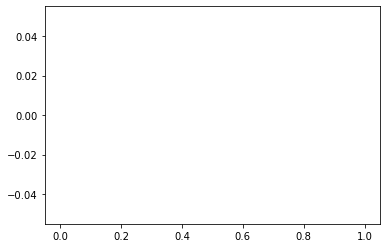

In [20]:
plt.hist(X[:, 0])
plt.show()

In [48]:
clf = LogisticRegressionCV(cv=3, max_iter=10000, random_state=123).fit(X[:, 1:], X[:, 0])
clf = RandomForestClassifier(bootstrap=True, min_samples_leaf=10).fit(X[:, 1:], X[:, 0])

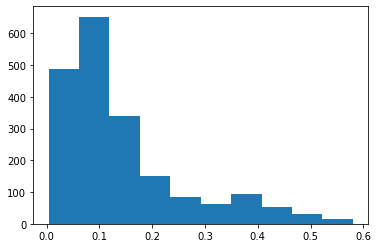

In [49]:
plt.hist(clf.predict_proba(X[:, 1:])[:, 1])
plt.show()

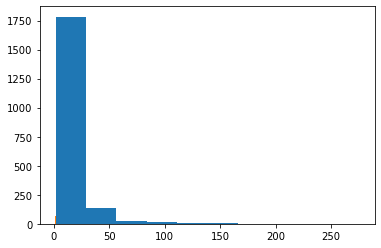

In [50]:
plt.hist(1 / clf.predict_proba(X[:, 1:])[:, 1])
plt.hist(1 / clf.predict_proba(X[:, 1:])[:, 0])
plt.show()

In [53]:
from utilities import PluginRR

plugin_fn = lambda: PluginRR(model_t=LogisticRegressionCV(cv=3, max_iter=10000, random_state=123),
                             min_propensity=0)
est = DebiasedMoment(moment_fn=moment_fn, reg_fn=reg_fn, reisz_fn=plugin_fn, n_splits=1)

In [54]:
est.fit(X, y)

In [55]:
print(est.avg_moment())

(1837.4791195079943, 1565.8853379082452, -1233.4874818137378, 4908.445720829726)


In [56]:
print(est.avg_moment(tmle=True))

(1832.5780825010445, 1564.7203946255631, -1236.1038675585908, 4901.26003256068)


In [156]:
import pandas as pd

df = pd.read_csv(f'401k/quintile1_trimmed.csv', index_col=0)
y = df['Y'].values
X = df[['D'] + [f'X{i}' for i in np.arange(1, 10)]].values
y = y.astype(np.double)
X = X.astype(np.double)

# clf = RandomForestClassifier(bootstrap=True, min_samples_leaf=5).fit(X[:, 1:], X[:, 0])
# prop = clf.predict_proba(X[:, 1:])
# filt = (prop[:, 1] <= .9) & (prop[:, 1] >= .1)
# print(X.shape[0], np.sum(filt))
# X, y = X[filt], y[filt]

X[:, 1:5] = StandardScaler().fit_transform(X[:, 1:5])
y_scale = np.std(y)
y = y / y_scale
inds = np.arange(X.shape[0])
np.random.seed(123)
np.random.shuffle(inds)
X, y = X[inds].copy(), y[inds].copy()

In [157]:
get_reisz_fn = lambda X: lambda: AdvKernelReisz(kernel=lambda X, Y=None: prod_kernel(X, Y=Y, gamma=1.0/X.shape[1]),
                                  regm='auto', regl='auto')
est = DebiasedMoment(moment_fn=moment_fn, get_reg_fn=get_reg_fn,
                     get_reisz_fn=get_reisz_fn, n_splits=1)
est.fit(X, y)
print([i * y_scale for i in est.avg_moment()])
print([i * y_scale for i in est.avg_moment(tmle=True)])

[3581.6611524055743, 886.3341444347128, 1843.4096410873371, 5319.912663723811]
[3588.7276388264386, 886.4982733947618, 1850.154242793901, 5327.301034858976]


In [158]:
print([i * y_scale for i in est.avg_moment(tmle=True)])

[3588.7276388264386, 886.4982733947618, 1850.154242793901, 5327.301034858976]


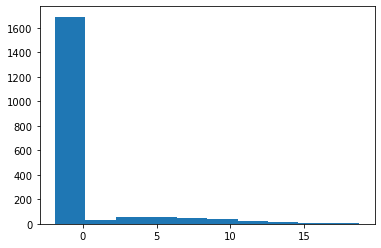

In [159]:
plt.hist(est.reisz_models_[0].predict(X))
plt.show()

In [160]:
print(est.reisz_models_[0].scores_)

[5929.062983542529, 13148.093262485821, 1015.8691957106873, 424.7404779759171, 25.132943419432443, 0.665262465834437, -2.3096214782437106e-05, 11783.0454577003, 46169.959596986155, 65120.70669147864, 68814.37576636716, 69008.78683626204, 69012.64075743068, 69012.69855578215]


In [161]:
print(est.reisz_models_[0].regl_)

3.455107294592218e-05


In [162]:
get_reisz_fn = lambda X: lambda: KernelReisz(kernel=lambda X, Y=None: prod_kernel(X, Y=Y, gamma=1.0/X.shape[0]),
                               regl='auto')
kest = DebiasedMoment(moment_fn=moment_fn, get_reg_fn=get_reg_fn,
                     get_reisz_fn=get_reisz_fn, n_splits=1)
kest.fit(X, y)
print([i * y_scale for i in kest.avg_moment()])
print([i * y_scale for i in kest.avg_moment(tmle=True)])

[3548.123161623499, 951.165144356365, 1682.7270691090164, 5413.519254137981]
[3550.469466009094, 951.1953484612412, 1685.0141381246567, 5415.924793893531]


In [163]:
print(kest.reisz_models_[0].scores_)

[-8.582181791610026, -8.568752077816722, -7.30161598870282, -9.29849183453675, -10.103027078375462, -9.653674389523664, -8.677850092762311, -8.231716556434703, -5.880250316306816, -1.8279555844612512, -0.30344520976230405, -0.03932795563909257]


In [164]:
print(kest.reisz_models_[0].regl_)

4.328761281083062e-05


In [165]:
from utilities import PluginRR

get_plugin_fn = lambda X: lambda: PluginRR(model_t=RandomForestClassifier(bootstrap=True, min_samples_leaf=10),
                             min_propensity=0)
rfest = DebiasedMoment(moment_fn=moment_fn, get_reg_fn=get_reg_fn,
                     get_reisz_fn=get_plugin_fn, n_splits=1)
rfest.fit(X, y)
print([i * y_scale for i in rfest.avg_moment()])
print([i * y_scale for i in rfest.avg_moment(tmle=True)])

[3716.3684185039983, 616.0653245261583, 2508.1598798254627, 4924.576957182534]
[4226.297544979248, 616.2127978850544, 3017.7997860437813, 5434.795303914715]


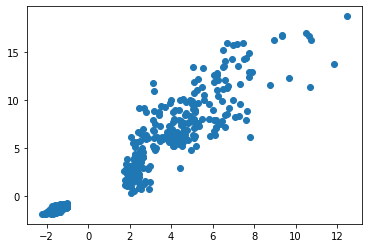

In [166]:
plt.scatter(rfest.reisz_models_[0].predict(X), est.reisz_models_[0].predict(X))
plt.show()

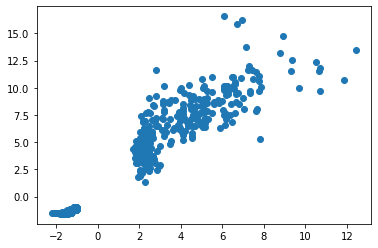

In [167]:
plt.scatter(rfest.reisz_models_[0].predict(X), kest.reisz_models_[0].predict(X))
plt.show()